# Structured outputs

## with_structured_output

In [1]:
from typing import List, Optional
from pydantic import BaseModel, Field

class UserProfile(BaseModel):
    name: str = Field(
        description="The user's preferred name.",
    )
    profession: str = Field(
        description="The user's profession or job title.",
    )
    seniority: Optional[str] = Field(
        description="The user's seniority level, e.g., 'mid-level', 'senior', etc. If unknown, guess it based on profession description",
    )
    languages: List[str] = Field(
        description="A list of programming languages the user is proficient in.",
    )
    frameworks: List[str] = Field(
        description="A list of frameworks or major technologies the user uses.",
    )
    current_project: Optional[str] = Field(
        description="The user's current main project.",
    )
    skills: List[str] = Field(
        description="A list of the user's technical or professional skills.",
    )
    current_interest: Optional[str] = Field(
        description="The user's current main interest or focus, e.g., a topic or technology they are actively exploring or asking about.",
    )

In [2]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

model = ChatOpenAI(model="gpt-4o-mini")
structured_model = model.with_structured_output(UserProfile)

profile = structured_model.invoke([HumanMessage(content="""
Hey, how are you? I am Evgeny, I am a software engineer and I need your help with 
my project. This is a TaskManager Java Spring Boot application. I do not get how
to configure security there!
""")])
print(profile.model_dump_json(indent=4))

{
    "name": "Evgeny",
    "profession": "Software Engineer",
    "seniority": "mid-level",
    "languages": [
        "Java"
    ],
    "frameworks": [
        "Spring Boot"
    ],
    "current_project": "TaskManager Application",
    "skills": [
        "Java Development",
        "Spring Framework",
        "RESTful APIs"
    ],
    "current_interest": "Configuring security in Java Spring Boot applications"
}


{
  "$schema": "https://json-schema.org/draft/2020-12/schema",
  "type": "object",
  "properties": {
    "name": {
      "type": "string",
      "description": "The user's preferred name."
    },
    "profession": {
      "type": "string",
      "description": "The user's profession or job title."
    },
    "seniority": {
      "type": ["string", "null"],
      "description": "The user's seniority level, e.g., 'mid-level', 'senior', etc. 
                         If unknown, guess it based on profession description"
    },
    ...
  },
  "required": ["name", "profession", "languages", "frameworks", "skills"],
  "additionalProperties": false
}

Hey, how are you? I am Evgeny, I am a software engineer and I need your help with 
my project. This is a TaskManager Java Spring Boot application. I do not get how
to configure security there!

### Why Classical Prompt-Based Structured Output Is Problematic

1. No Structural Guarantees

The LLM still generates raw text. Parsing is a best-effort guess — not a guarantee. What can go wrong:

- Missing fields
- Wrong types ("25" instead of 25)
- Extra fields added
- Malformed JSON
- Incomplete output

2. Full Regeneration on Every Prompt

LLMs rebuild the entire structure every time. It can’t update just one field.

Why it’s a problem:

- You can’t merge or incrementally fill data
- Schema updates break old extractions
- You risk data loss on every re-generation
- Price and Time - you are paying for every token that was repeated, bigger prompts tak more time to process


3. Parsing Is Still Fragile

Libraries help, but they can’t prevent:

- Markdown fences (```json) around JSON
- Trailing commas, weird spacing
- Fields outside the expected structure

## Tool calling

In [3]:
from langchain_core.messages import HumanMessage

model_with_tools = model.bind_tools(
    [UserProfile], 
    strict=True
)

response = model_with_tools.invoke([HumanMessage(content="""
Hey, how are you? I am Evgeny, I am a software engineer and I need your help with 
my project. This is a TaskManager Java Spring Boot application. I do not get how
to configure security there!
""")])
print(response.model_dump_json(indent=4))

{
    "content": "",
    "additional_kwargs": {
        "tool_calls": [
            {
                "id": "call_ITARPAkJsl9sZSrMZBkhZJU3",
                "function": {
                    "arguments": "{\"name\":\"Evgeny\",\"profession\":\"Software Engineer\",\"seniority\":null,\"languages\":[\"Java\"],\"frameworks\":[\"Spring Boot\"],\"current_project\":\"TaskManager Java Spring Boot application\",\"skills\":[],\"current_interest\":\"Configuring security in Spring Boot\"}",
                    "name": "UserProfile"
                },
                "type": "function"
            }
        ],
        "refusal": null
    },
    "response_metadata": {
        "token_usage": {
            "completion_tokens": 61,
            "prompt_tokens": 230,
            "total_tokens": 291,
            "completion_tokens_details": {
                "accepted_prediction_tokens": 0,
                "audio_tokens": 0,
                "reasoning_tokens": 0,
                "rejected_prediction_tokens

In [10]:
response.additional_kwargs["tool_calls"][0]["function"]["arguments"]

'{"name":"Evgeny","profession":"Software Engineer","seniority":null,"languages":["Java"],"frameworks":["Spring Boot"],"current_project":"TaskManager Java Spring Boot application","skills":[],"current_interest":"Configuring security in Spring Boot"}'

In [11]:
import json

tool_call_data_raw = response.additional_kwargs["tool_calls"][0]["function"]["arguments"]
tool_call_data = json.loads(tool_call_data_raw)

profile = UserProfile(**tool_call_data)

print(profile.model_dump_json(indent=4))

{
    "name": "Evgeny",
    "profession": "Software Engineer",
    "seniority": null,
    "languages": [
        "Java"
    ],
    "frameworks": [
        "Spring Boot"
    ],
    "current_project": "TaskManager Java Spring Boot application",
    "skills": [],
    "current_interest": "Configuring security in Spring Boot"
}


### What about Tooling ?

1. No Structural Guarantees → Improved

- Tool calling enforces a valid schema: arguments must match expected structure.
- Eliminates issues like malformed JSON, markdown wrappers, and invalid formatting.

2. Parsing Is Still Fragile → Improved

- Tool calling returns clean structured data.
- No need for manual parsing, cleanup, or error-prone regex hacks.

3. Full Regeneration on Every Prompt - Still a Problem

- The model still regenerates the full object each time.
- Partial updates and field-level diffs are not supported.
- You still pay for repeated content and risk data loss if the model forgets a field.

## update profile

In [4]:
from trustcall import create_extractor
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-mini")
trustcall_extractor = create_extractor(model, tools=[UserProfile])


# Invoke the extractor
result = trustcall_extractor.invoke([HumanMessage(content="""
Hey, how are you? I am Evgeny, I am a software engineer and I need your help with 
my project. This is a TaskManager Java Spring Boot application. I do not get how
to configure security there!
""")])

result

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_C06fypvYfnCYTVzCNIjEHqH0', 'function': {'arguments': '{"name":"Evgeny","profession":"Software Engineer","seniority":null,"languages":["Java"],"frameworks":["Spring Boot"],"current_project":"TaskManager Java Spring Boot application","skills":[],"current_interest":"Configuring security in Spring Boot application"}', 'name': 'UserProfile'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 262, 'total_tokens': 324, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C5uZ13d8ZneX6f4R4Ohlw7OY7GQ9x', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c306805c-c676-4

In [5]:
schema = result["responses"]
schema

[UserProfile(name='Evgeny', profession='Software Engineer', seniority=None, languages=['Java'], frameworks=['Spring Boot'], current_project='TaskManager Java Spring Boot application', skills=[], current_interest='Configuring security in Spring Boot application')]

In [6]:
profile = schema[0].model_dump()
profile

{'name': 'Evgeny',
 'profession': 'Software Engineer',
 'seniority': None,
 'languages': ['Java'],
 'frameworks': ['Spring Boot'],
 'current_project': 'TaskManager Java Spring Boot application',
 'skills': [],
 'current_interest': 'Configuring security in Spring Boot application'}

In [7]:
message = """
Update the memory (JSON doc) to incorporate new information from the following conversation:
<conversation>
I also can develop in Kotlin and ReactJS
</conversation>
"""

result = trustcall_extractor.invoke(
    {
        "messages": [HumanMessage(content=message)], 
        "existing": {"UserProfile": profile}
    }
)  

profile_after_update = result["responses"][0].model_dump()
profile_after_update

{'name': 'Evgeny',
 'profession': 'Software Engineer',
 'seniority': None,
 'languages': ['Java', 'Kotlin'],
 'frameworks': ['Spring Boot', 'ReactJS'],
 'current_project': 'TaskManager Java Spring Boot application',
 'skills': [],
 'current_interest': 'Configuring security in Spring Boot application'}

## Chat bot with profile updates

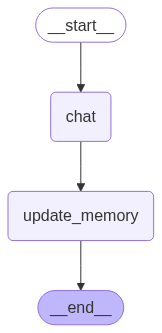

In [8]:
from IPython.display import Image, display
from langchain_openai import ChatOpenAI

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables.config import RunnableConfig
from langgraph.store.base import BaseStore
from langchain_core.messages import SystemMessage
from langgraph.store.memory import InMemoryStore

long_term_memory = InMemoryStore()

user_id = "1"
namespace = (user_id, "memory")
key = "profile"

profile = None

long_term_memory.put(namespace, key, profile)



model = ChatOpenAI(model="gpt-4o-mini")

### Nodes

def chat(state: MessagesState, config: RunnableConfig, store: BaseStore):
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    profile = store.get((user_id, "memory"), "profile")

    # Extract the actual memory content if it exists and add a prefix
    if profile:
        profile_content = profile.value
    else:
        profile_content = None

    # Format the memory in the system prompt
    system_msg = f"""
    You are a helpful assistant with memory capabilities.
    If user-specific memory is available, use it to personalize 
    your responses based on what you know about the user.
    
    Your goal is to provide relevant, friendly, and tailored 
    assistance that reflects the user’s preferences, context, and past interactions.

    If the user’s name or relevant personal context is available, always personalize your responses by:
        – Addressing the user by name (e.g., "Sure, Bob...") when appropriate
        – Referencing known projects, tools, or preferences (e.g., "your MCP  server typescript based project")
        – Adjusting the tone to feel friendly, natural, and directly aimed at the user

    Avoid generic phrasing when personalization is possible. For example, instead of "In TypeScript apps..." say "Since your project is built with TypeScript..."

    Use personalization especially in:
        – Greetings and transitions
        – Help or guidance tailored to tools and frameworks the user uses
        – Follow-up messages that continue from past context

    Always ensure that personalization is based only on known user details and not assumed.
    Tailor your answers to level of seniority of the user if it's known.
    
    The user’s profile (which may be empty) is provided as JSON (extract all data and use it): {profile_content}
    """

    response = model.invoke([SystemMessage(content=system_msg)] + state["messages"])

    return {"messages": response}


def update_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    user_id = config["configurable"]["user_id"]
    namespace = (user_id, "memory")
    key = "profile"
    profile = store.get(namespace, key)
        

    if profile:
        profile_content = profile.value
    else:
        profile_content = None


    # Format the memory in the system prompt
    system_msg = f"""
    Update the user profile using the user's chat history.
    Save this for future reference. If a profile already exists, just update it.
    """

    if not profile_content:
        print("Create profile")
        updated_profile = trustcall_extractor.invoke(state['messages'])
    else:
        print("Update profile")
        updated_profile = trustcall_extractor.invoke(
            {
                "messages": [SystemMessage(content=system_msg)] + state['messages'], 
                "existing": {"UserProfile": profile_content}
            }
        )

    store.put(namespace, key, updated_profile["responses"][0].model_dump())


# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("chat", chat)
builder.add_node("update_memory", update_memory)
builder.add_edge(START, "chat")
builder.add_edge("chat", "update_memory")
builder.add_edge("update_memory", END)

short_term_memory = MemorySaver()

graph = builder.compile(checkpointer=short_term_memory, store=long_term_memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [9]:
# start a new conversation
thread = {"configurable": {"thread_id": "1", "user_id": "1"}}

# define intiial user request
initial_input = {"messages": HumanMessage(content="""
Hey, I am Evgeny, a junior software engineer and I need your help with my project. 
This is a TaskManager Java Spring Boot application.
""")}

# run the graph and stream in values mode
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================


Hey, I am Evgeny, a junior software engineer and I need your help with my project. 
This is a TaskManager Java Spring Boot application.

================================== Ai Message ==================================

Hi Evgeny! It’s great to hear from you. I'd be happy to help with your TaskManager Java Spring Boot application. What specific challenges are you facing, or what help do you need with the project?
Create profile


In [12]:
user_id = thread["configurable"]["user_id"]
namespace = (user_id, "memory")
key = "profile"
profile = long_term_memory.get(namespace, key)
profile.dict()

{'namespace': ['1', 'memory'],
 'key': 'profile',
 'value': {'name': 'Evgeny',
  'profession': 'Software Engineer',
  'seniority': 'junior',
  'languages': ['Java'],
  'frameworks': ['Spring Boot'],
  'current_project': 'TaskManager application',
  'skills': [],
  'current_interest': None},
 'created_at': '2025-08-18T13:52:41.801216+00:00',
 'updated_at': '2025-08-18T13:52:41.801216+00:00'}

In [13]:
# start a new conversation
thread = {"configurable": {"thread_id": "2", "user_id": "1"}}

# define intiial user request
initial_input = {"messages": HumanMessage(content="""
I also use Kotlin and I do not get how to set up security configuration in my project!
""")}

# run the graph and stream in values mode
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================


I also use Kotlin and I do not get how to set up security configuration in my project!

================================== Ai Message ==================================

Hi Evgeny! Since you’re working on a TaskManager application, setting up security in a Spring Boot project with Kotlin can be quite straightforward. Here's a basic outline to help you get started with security configuration.

1. **Add Dependencies**: Make sure you have the Spring Security dependency in your `build.gradle.kts` file:

   ```kotlin
   dependencies {
       implementation("org.springframework.boot:spring-boot-starter-security")
       // other dependencies
   }
   ```

2. **Create a Security Configuration Class**: You can create a class annotated with `@Configuration` and `@EnableWebSecurity`. Here’s a simple setup to start with:

   ```kotlin
   import org.springframework.context.annotation.Bean
   import org.springframewor

In [14]:
user_id = thread["configurable"]["user_id"]
namespace = (user_id, "memory")
key = "profile"
profile = long_term_memory.get(namespace, key)
profile.dict()

{'namespace': ['1', 'memory'],
 'key': 'profile',
 'value': {'name': 'Evgeny',
  'profession': 'Software Engineer',
  'seniority': 'junior',
  'languages': ['Java', 'Kotlin'],
  'frameworks': ['Spring Boot'],
  'current_project': 'TaskManager application',
  'skills': [],
  'current_interest': 'Setting up security configuration in projects.'},
 'created_at': '2025-08-18T14:02:37.449871+00:00',
 'updated_at': '2025-08-18T14:02:37.449871+00:00'}